parameters from the paper

In [1]:
import numpy as np
import visualkeras as vk 
import random

from keras import Model
from keras.models import load_model
from keras.optimizers import gradient_descent_v2
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input, Conv2DTranspose, concatenate
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.utils import shuffle
from skimage.io import imshow

train_data = np.load("../datasets/Amharic character Image dataset/Type-II/train_char/X_train_char.npy")
test_data = np.load("../datasets/Amharic character Image dataset/Type-II/test_char/X_test_char.npy")
train_labels = np.load("../datasets/Amharic character Image dataset/Type-II/train_char/y_train_char.npy")
test_labels = np.load("../datasets/Amharic character Image dataset/Type-II/test_char/y_test_char.npy")

# Normalization 

train_data = train_data / 255.0
test_data = test_data / 255.0

# Changing the old labels to row-column

# training labels
train_labels_row = []
train_labels_col = []

for label in train_labels:
    row, col = divmod(label, 7)
    train_labels_row.append(row)
    train_labels_col.append(col)

train_labels_row = np_utils.to_categorical(train_labels_row)
train_labels_col = np_utils.to_categorical(train_labels_col)

# test labels
test_labels_row = []
test_labels_col = []

for label in test_labels:
    row, col = divmod(label, 7)
    test_labels_row.append(row)
    test_labels_col.append(col)

test_labels_row = np_utils.to_categorical(test_labels_row)
test_labels_col = np_utils.to_categorical(test_labels_col)


In [2]:
# Changing the old labels to row-column

# training labels
train_labels_row = []
train_labels_col = []

for label in train_labels:
    row, col = divmod(label, 7)
    train_labels_row.append(row)
    train_labels_col.append(col)

train_labels_row = np_utils.to_categorical(train_labels_row)
train_labels_col = np_utils.to_categorical(train_labels_col)

# test labels
test_labels_row = []
test_labels_col = []

for label in test_labels:
    row, col = divmod(label, 7)
    test_labels_row.append(row)
    test_labels_col.append(col)

test_labels_row = np_utils.to_categorical(test_labels_row)
test_labels_col = np_utils.to_categorical(test_labels_col)

print(train_labels_row.shape, train_labels_col.shape, test_labels_row.shape, test_labels_col.shape, sep='\n')

(70194, 33)
(70194, 7)
(7800, 33)
(7800, 7)


In [3]:
# Model

# feature extraction UNET

input = Input(train_data.shape[1:])

conv1 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (input)
conv1 = Dropout(rate=0.1) (conv1)
conv1 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (conv1)
maxpool1 = MaxPool2D(pool_size=2) (conv1)
conv2 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (maxpool1)
conv2 = Dropout(rate=0.1) (conv2)
conv2 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (conv2)
maxpool2 = MaxPool2D(pool_size=2) (conv2)
conv3 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (maxpool2)
conv3 = Dropout(rate=0.1) (conv3)
conv3 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (conv3)

upconv4 = Conv2DTranspose(32, 2, strides=2, padding='same') (conv3)
upconv4 = concatenate(inputs=[upconv4, conv2])
conv4 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (upconv4)
conv4 = Dropout(rate=0.1) (conv4)
conv4 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (conv4)
upconv5 = Conv2DTranspose(16, 2, strides=2, padding='same') (conv4)
upconv5 = concatenate(inputs=[upconv5, conv1])
conv5 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (upconv5)
conv5 = Dropout(rate=0.1) (conv5)
conv5 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (conv5)
extractor_output = MaxPool2D(pool_size=2) (conv5) # breaks the symmetricity

# classification multi-task learing CNN 

flatten = Flatten() (extractor_output)
fc1 = Dense(512, activation='relu') (flatten)
fc2 = Dense(512, activation='relu') (fc1)                   # neurons?

row = Dense(units=33, activation='softmax', name='row') (fc2)
col = Dense(units=7, activation='softmax', name='col') (fc2)

model = Model(inputs=input, outputs=[row, col], name='FCNN')

model.compile(
    optimizer='adam',
    loss=[
        'categorical_crossentropy', 
        'categorical_crossentropy'  
    ], 
    loss_weights = None,
    metrics=['accuracy']
) 

In [4]:
# Combined accuracy metrics

class CombinedMetric(Callback):
    def __init__(self):
        super(CombinedMetric, self).__init__()

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        logs['accuracy'] = (logs["row_accuracy"] + logs["col_accuracy"]) / 2
        logs['val_accuracy'] = (logs["val_row_accuracy"] + logs["val_col_accuracy"]) / 2

In [5]:
callbacks = [
    ModelCheckpoint(
        filepath="../datasets/Amharic character Image dataset/models/fcnn-arct/paper_best_loss_model.h5",
        monitor="loss",
        save_best_only=True,
        save_weights_only=False,
        mode="min"
    ),

    ModelCheckpoint(
        filepath="../datasets/Amharic character Image dataset/models/fcnn-arct/paper_best_val_loss_model.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False, 
        mode="min"
    ),

    EarlyStopping(
        monitor = 'val_loss',
        patience = 10
    ),

    TensorBoard(
        log_dir="../datasets/Amharic character Image dataset/models/fcnn-arct"
    ),

    CombinedMetric()
]

In [6]:
history = model.fit(
    train_data,
    [train_labels_row, train_labels_col],
    validation_data=(test_data, [test_labels_row,test_labels_col]), 
    epochs=100, 
    batch_size=256, 
    callbacks=[callbacks]
)

Epoch 1/100
275/275 [==============================] - 16s 41ms/step - loss: 2.6906 - row_loss: 1.5922 - col_loss: 1.0983 - row_accuracy: 0.5972 - col_accuracy: 0.6057 - val_loss: 0.7647 - val_row_loss: 0.3957 - val_col_loss: 0.3690 - val_row_accuracy: 0.8991 - val_col_accuracy: 0.8967 - accuracy: 0.6015 - val_accuracy: 0.8979
Epoch 2/100
275/275 [==============================] - 10s 37ms/step - loss: 0.5894 - row_loss: 0.2930 - col_loss: 0.2964 - row_accuracy: 0.9276 - col_accuracy: 0.9138 - val_loss: 0.4832 - val_row_loss: 0.2311 - val_col_loss: 0.2521 - val_row_accuracy: 0.9406 - val_col_accuracy: 0.9296 - accuracy: 0.9207 - val_accuracy: 0.9351
Epoch 3/100
275/275 [==============================] - 10s 37ms/step - loss: 0.4120 - row_loss: 0.2019 - col_loss: 0.2101 - row_accuracy: 0.9478 - col_accuracy: 0.9372 - val_loss: 0.4191 - val_row_loss: 0.2042 - val_col_loss: 0.2149 - val_row_accuracy: 0.9440 - val_col_accuracy: 0.9385 - accuracy: 0.9425 - val_accuracy: 0.9412
Epoch 4/100
2

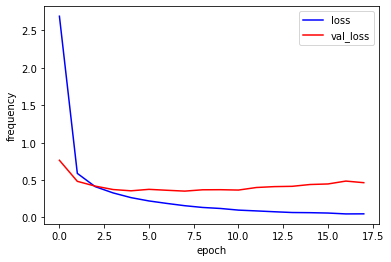

In [7]:
plt.plot(history.history["loss"], 'b', label="loss")
plt.plot(history.history["val_loss"], 'r', label="val_loss")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

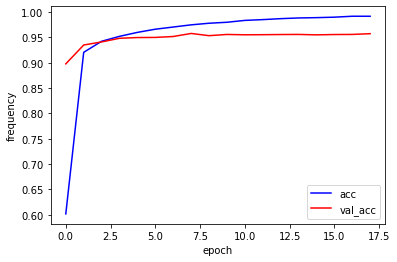

In [8]:
plt.plot(history.history["accuracy"], 'b', label="acc")
plt.plot(history.history["val_accuracy"], 'r', label="val_acc")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

In [9]:
model = load_model("../datasets/Amharic character Image dataset/models/fcnn-arct/paper_best_val_loss_model.h5")

loss, _, _, row_acc, col_acc = model.evaluate(test_data, [test_labels_row,test_labels_col], verbose=False)

print('row_accuracy: {:5.4f}%'.format(100 * row_acc))
print('col_accuracy: {:5.4f}%'.format(100 * col_acc))
print()
print('accuracy: {:5.4f}%'.format(100 * (row_acc + col_acc)/2))
print('val_loss: {:5.4f}%'.format(100 * loss))

row_accuracy: 96.1154%
col_accuracy: 95.4744%

accuracy: 95.7949%
val_loss: 35.2310%


## Combined Accuracy

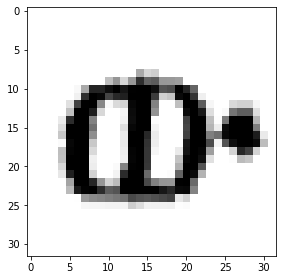

In [10]:
imshow(test_data[random.randint(0,len(test_data))])

In [11]:
pred_row, pred_col, pred_char, mispred = 0,0,0,0

for i in range(len(test_data)):
    test_image = np.reshape(test_data[i], (1,32,32,1))
    row_pred, col_pred = model.predict(test_image)
    if (np.argmax(row_pred) ==  np.argmax(test_labels_row[i]) and np.argmax(col_pred) ==  np.argmax(test_labels_col[i])):
        pred_char += 1
    elif (np.argmax(row_pred) ==  np.argmax(test_labels_row[i])):
        pred_row += 1
    elif (np.argmax(col_pred) ==  np.argmax(test_labels_col[i])):
        pred_col += 1
    elif (np.argmax(row_pred) !=  np.argmax(test_labels_row[i]) and np.argmax(col_pred) !=  np.argmax(test_labels_col[i])):
        mispred += 1
    else:
        pass

In [12]:
print('row_accuracy: {:5.4f}%'.format(100 * (pred_row + pred_char) / len(test_data)))
print('col_accuracy: {:5.4f}%'.format(100 * (pred_col + pred_char) / len(test_data)), '\n')

print('overall accuracy: {:5.4f}%'.format(100 * (pred_char) / len(test_data)))
print('val_loss: {:5.4f}%'.format(100 * loss))

row_accuracy: 96.1154%
col_accuracy: 95.4744% 

overall accuracy: 93.3718%
val_loss: 35.2310%


In [13]:
print(pred_row, pred_col, pred_char, mispred, sep = '\n')

print(pred_row/78, pred_col/78, pred_char/78, mispred/78, sep = '\n')

214
164
7283
139
2.7435897435897436
2.1025641025641026
93.37179487179488
1.7820512820512822
